# Alternative explanations: Genetic drift and Pool-Nielsen effect

---

Variables to allow differentation of file names for analyses based on different calling criteria. Should be commented out when run in batch with `slurm-jupyter-run.py`

**NB:** comment out the cell below if you want to run using `slurm-jupyter-run.py`. Otherwise it will overwrite variables set by `slurm-jupyter-run.py`.

In [1]:
from nb_parameters import extract_parameter_code
exec(extract_parameter_code('nb_parameters.ipynb', '5e-05_25%'))

----

In [3]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)

Plotting setup:

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

import random
df = DataFrame({'x': random.sample(range(1, 100), 5), 
                'y': random.sample(range(1, 100), 5),
                'z': [1,0,0,1,0],
                'k': ['male','male','male','female','female'] })

Ignore deprecation warnings from mainly seaborn:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### Analysis dirs

In [6]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Local code in the scripts dir on the cluster:

In [7]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

In [8]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

## Simulate a frequency trajectory

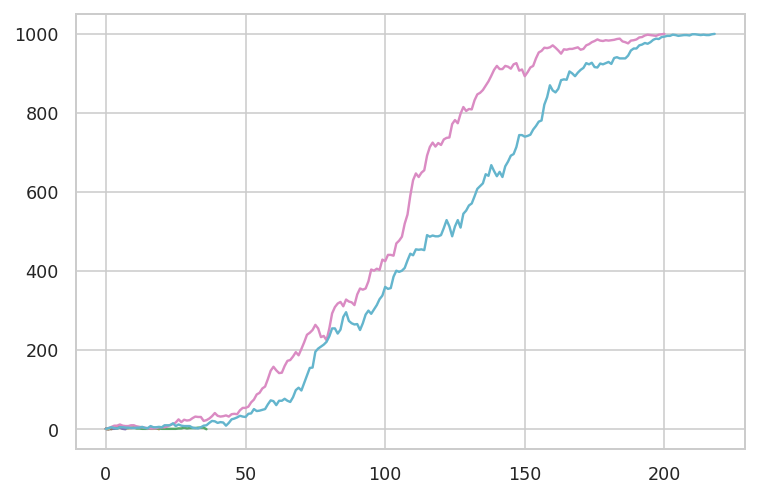

In [9]:
def freq_trajectory(N, n=1, s=0):
    yield n
    while N > n > 0:
        n = numpy.random.binomial(N, n*(1+s)/((N-n)+(n)*(1+s)), 1)[0]
        yield n

for i in range(10):
    trajectory = list(freq_trajectory(1000, n=1, s=0.05))
    plt.plot(trajectory)

Compute the probability that a single haplotype raise to some frequency in less than some number of generations without recombing.

In [8]:
from multiprocessing import Pool
from math import exp

# def norec_freq_reached(N, allele_count, g, r, L, n_samples=100000):
#     min_allele_count_reached = 0
#     for i in range(n_samples):
#         trajectory = list(freq_trajectory(N, n=1, s=0))
#         max_freq = max(trajectory[:g])
#         if max_freq >= allele_count:
#             nr_gens = trajectory[:g].index(max_freq) + 1
#             min_allele_count_reached += (1-(r*L))**nr_gens
#     return min_allele_count_reached / n_samples

def work(N, allele_count, g, r, L):
    
    trajectory = list(freq_trajectory(N, n=1, s=0))
    max_freq = max(trajectory[:g])
    if max_freq >= allele_count:
        nr_gens = trajectory[:g].index(max_freq) + 1
#         return (1-(r*L))**nr_gens
        return exp(-r*L*g)
    return 0

def norec_freq_reached(N, allele_count, g, r, L, n_samples=100000):
    min_allele_count_reached = 0
#     for i in range(n_samples):
#         min_allele_count_reached += work(N, allele_count, g, r, L)
    with Pool(int(os.environ['SLURM_CPUS_PER_TASK'])) as p:
        min_allele_count_reached = sum(p.starmap(work, [(N, allele_count, g, r, L)]*n_samples))
    return min_allele_count_reached / n_samples


# N = 2 * 1000 * 3/4
# #N = 2 * 1000
# r = 1e-8 
# g = 344
# L = 5e5
# n_samples = 100000000

N = 2 * 3000 * 0.66 * 0.73
r = 0.46e-8 
g = 344
L = 5e5
n_samples = 100000000

numpy.random.seed(7)

lst = list()

target_freqs = numpy.linspace(0, 1, 11)
for f in target_freqs:
    allele_count = f * N
    p = norec_freq_reached(N, allele_count, g, r, L, n_samples=n_samples)
    prob_any_allele = 1 - (1-p)**N
    lst.append(prob_any_allele)
    print(f, prob_any_allele)

0.0 1.0
0.1 0.934622419600688
0.2 0.3075996023040558
0.3 0.04081475270994417
0.4 0.005097532103314206
0.5 0.0
0.6 0.0
0.7 0.0
0.8 0.0
0.9 0.0
1.0 0.0


Results:

    0.0 1.0
    0.1 0.8042639485907703
    0.2 0.42236999201683256
    0.3 0.17070750748121732
    0.4 0.05948008524273962
    0.5 0.018600046895680733
    0.6 0.004422087359309268
    0.7 0.0007786346523135368
    0.8 8.057652222803746e-05
    0.9 2.6859561635839135e-05
    1.0 0.0



Old results:

    0.0 1.0
    0.1 0.9505932718582353
    0.2 0.5298689815392876
    0.3 0.16527173980385934
    0.4 0.040351273355528905
    0.5 0.007807835143471498
    0.6 0.0012676017457843303
    0.7 0.00014250731399811922
    0.8 0.0
    0.9 0.0

In [9]:
max_p = exp(-r*L*g) / n_samples
max_p, 1 - (1-max_p)**N

(4.533005081656015e-09, 1.3103925264768002e-05)

In [10]:
((1-(r*L))**(g))/ n_samples

4.528876137436799e-09

In [17]:
#max_p = ((1-(r*L))**(g*0.5)) / n_samples
max_p = exp(-r*L*g) / n_samples

print('If it is zero, then it means that the prob is at most', 1 - (1-max_p)**N)

If it is zero, then it means that the prob is at most 0.013018556651099855


## Asgers computations

In [124]:
import numpy as np
#from statistics import harmonic_mean
from scipy.stats import hmean
#epoques = [(206, 100000), (311, 20000), (345, 12000), (344, 6000), (518, 4000), (689, 3000)]
epoques = [(206, 100000), (311, 20000), (345, 12000), (344, 6000), (518, 4000), (50, 3000)]
a = list()
gen_sum = 0
for g, N in epoques:
    gen_sum += g
    a.extend([N*0.66*0.73] * g)
hmean(a), gen_sum
#len(np.array(a)) / np.sum(1.0/a) 

(3420.7684303209794, 1774)

In [125]:
1774 / (3420*2)

0.25935672514619884

In [12]:
import rpy2

In [16]:
%load_ext rpy2.ipython

In [131]:
%%R -o prbv

## Consider a unlabelled sample of size n.
## We calculate the probability that j, 1<=j<=n of the samples coalesce before time t, 
## i.e. that there are 0,...,n-1 coalescent events before time t.
t <- 0.25
n <- 140
prbv <- rep(0,n)
##------------------------------------------------------
lamv <- choose(1:n,2) ## lamv[2]=1, lamv[3]=6 etc.
## j=1 (no coalescent events before time t)
prbv[1] <- exp(-lamv[n]*t)
## j=n (n-1 coalescent events before time t)
tmp <- 0
for (i in 2:n){
  tmp <- tmp + ( 1-exp(-lamv[i]*t) )*prod( lamv[-c(1,i)]/(lamv[-c(1,i)]-lamv[i]))
}
prbv[n] <- tmp
## j=2 (one coalescent events before time t)
prbv[2] <- ( lamv[n]/(lamv[n]-lamv[n-1]) )*( exp(-lamv[n-1]*t)-exp(-lamv[n]*t) )
## if n>=4:
## j from 3 to n-1
for (j in 3:(n-1)){
  tmp <- 0
  for (i in (n-j+2):n){
    lmvtmp <- lamv[(n-j+2):n]
    tmp <- tmp + ( lamv[i]/(lamv[i]-lamv[n-j+1]) )*( exp(-lamv[n-j+1]*t)-exp(-lamv[i]*t) )*
      prod( lmvtmp[-(i-(n-j+2)+1)]/(lmvtmp[-(i-(n-j+2)+1)]-lamv[i]))
  }
  prbv[j] <- tmp
}
cat(prbv,"\n")
cat(sum(prbv),"\n")


0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1.373014e-284 2.04273e-284 1.593488e-276 1.802277e-268 7.991185e-261 6.335607e-253 1.429648e-245 8.887801e-238 6.051812e-231 6.094736e-223 -7.086151e-217 7.002948e-209 -2.813614e-202 4.79298e-195 -2.29483e-188 9.854828e-182 -4.275267e-175 1.226088e-168 -9.693495e-163 -4.324995e-157 -1.890989e-150 1.817569e-144 -1.42571e-138 3.042595e-133 -2.180142e-127 2.464226e-122 -7.112644e-117 -1.576281e-112 4.600031e-107 4.065448e-102 4.244649e-97 -7.968092e-92 2.527763e-87 -6.337456e-83 1.425288e-78 -1.846715e-74 6.751637e-71 -6.664098e-67 1.035669e-62 -1.547278e-59 -3.933413e-56 1.544824e-52 3.313909e-49 2.333316e-45 1.789935e-42 8.026656e-40 -3.844264e-37 3.725631e-34 3.592999e-31 1.991718e-29 7.219134e-26 7.352205e-24 2.79597e-21 2.517078e-19 3.403789e-17 2.74738e-15 1.762818e-13 8.679282e-12 3.152729e-10 8.993118e-09 1.887945e-07 3.04436e-06 3.65781e-05 0.0003300244 0

In [132]:
sum(list(prbv)[100:])

1.0000003733601648

## Pool-Nielsen effect

In [14]:
class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work
    there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

Population size reduction

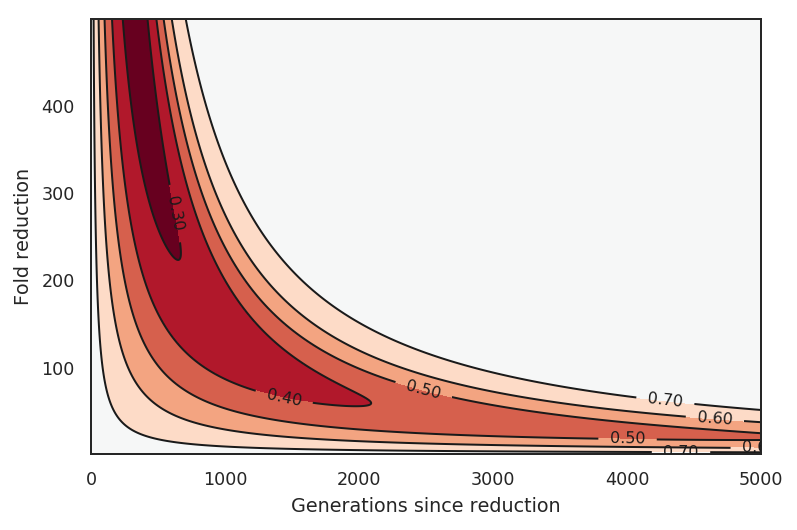

In [15]:
h = 0.75
N = 2e4
g = numpy.arange(0, 5e3)
f = 1 / numpy.arange(1, 500)

def reduction(g, f):
    return (2*N*h * (f - (f - 1) * numpy.exp(-g/(2*N*h*f)))) / \
           (2*N *   (f - (f - 1) * numpy.exp(-g/(2*N*  f)))) 

gg, ff = numpy.meshgrid(g, f, sparse=True)
z = reduction(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.1)
    plt.contourf(g, 1/f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g, 1/f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold reduction")
    plt.xlabel("Generations since reduction")

Population size increase:

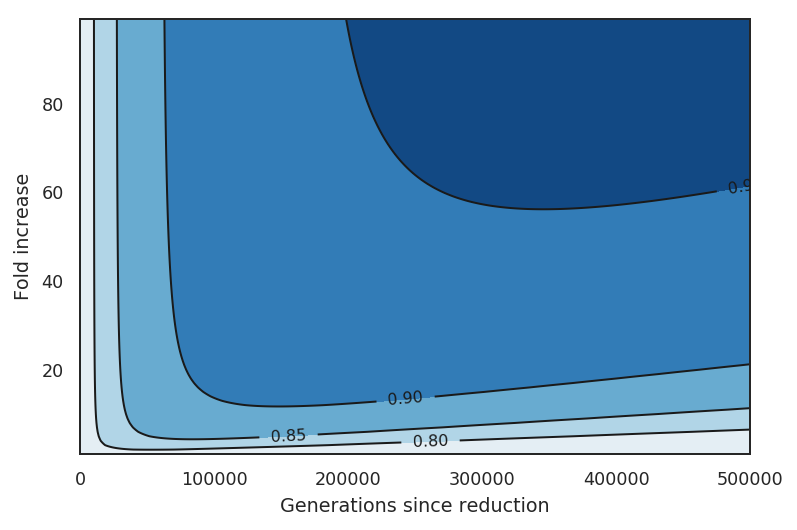

In [16]:
h = 0.75
N = 2e4
g = numpy.arange(0, 5e5, 100)
f = numpy.arange(1, 100)

def increase(g, f):
    return (2*N*h * (f - (f - 1) * numpy.exp(-g/(2*N*h*f)))) / \
           (2*N *   (f - (f - 1) * numpy.exp(-g/(2*N*  f)))) 

gg, ff = numpy.meshgrid(g, f, sparse=True)
z = reduction(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.05)
    plt.contourf(g, f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g, f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold increase")
    plt.xlabel("Generations since reduction")

Bottleneck

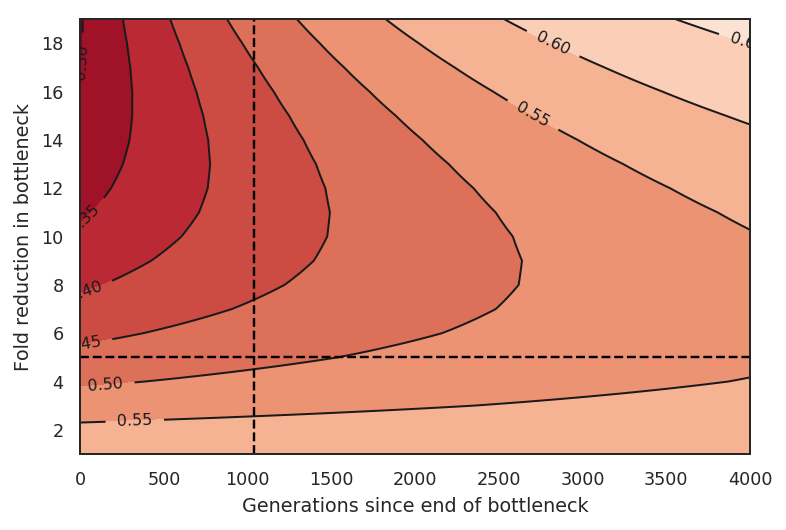

In [17]:
h = 0.6
N = 1e4
#f = 1 / np.arange(1, 500)
f = 1 / numpy.arange(1, 20)

bottle_len = 2413
bottle_end = numpy.arange(0, 4000)
g1 = bottle_end
g2 = bottle_len

def bottleneck(g1, f):
    return (2*N*h * (numpy.exp(-(f*g1+g2)/(2*N*h*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*h*f)) * (f - 1 + numpy.exp(g1/(2*N*h)))))) / \
           (2*N*1 * (numpy.exp(-(f*g1+g2)/(2*N*1*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*1*f)) * (f - 1 + numpy.exp(g1/(2*N*1))))))

gg, ff = numpy.meshgrid(g1, f, sparse=True)
z = bottleneck(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.05)
    plt.contourf(g1, 1/f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g1, 1/f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold reduction in bottleneck")
    plt.xlabel("Generations since end of bottleneck")

    plt.axhline(5, linestyle='dashed', color='black') 
    plt.axvline(1034, linestyle='dashed', color='black') # 30000 start of bottle

#    plt.savefig(str(figures_dir / 'pool_nielsen_bottleneck.pdf'))


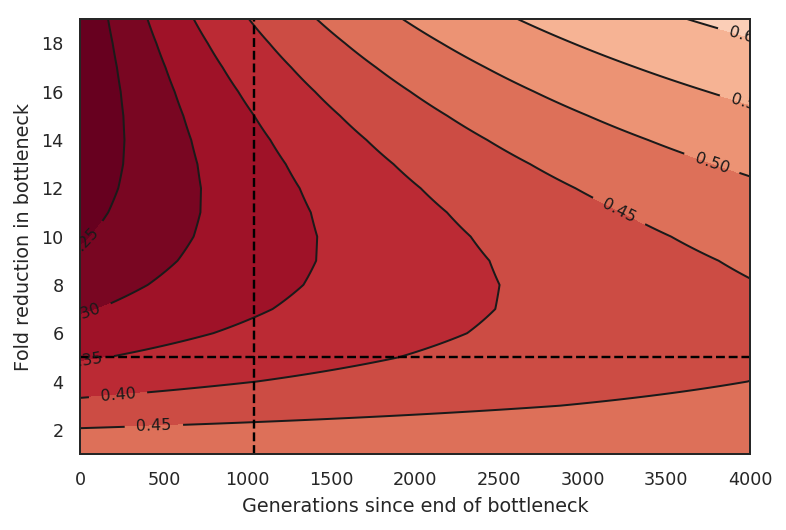

In [18]:
h = 0.5
N = 1e4
#f = 1 / np.arange(1, 500)
f = 1 / numpy.arange(1, 20)

bottle_len = 2413 # 70000
bottle_end = numpy.arange(0, 4000)
g1 = bottle_end
g2 = bottle_len

def bottleneck(g1, f):
    return (2*N*h * (numpy.exp(-(f*g1+g2)/(2*N*h*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*h*f)) * (f - 1 + numpy.exp(g1/(2*N*h)))))) / \
           (2*N*1 * (numpy.exp(-(f*g1+g2)/(2*N*1*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*1*f)) * (f - 1 + numpy.exp(g1/(2*N*1))))))

gg, ff = numpy.meshgrid(g1, f, sparse=True)
z = bottleneck(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.05)
    plt.contourf(g1, 1/f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g1, 1/f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold reduction in bottleneck")
    plt.xlabel("Generations since end of bottleneck")
    
#    plt.savefig(str(figures_dir / 'pool_nielsen_bottleneck.pdf'))

    plt.axhline(5, linestyle='dashed', color='black') 
    plt.axvline(1034, linestyle='dashed', color='black') # 30000 start of bottle


In [10]:
import numpy as np

def exp_coal(g, N):
    return 2*N - (g * np.exp(-g/(2*N))) / (1 - np.exp(-g/(2*N)))

expectation = 0
g_prev = None
for g, N in pairs:
    if g_prev is None:
        expectation += exp_coal(g, N)
    else:
        np.exp(-g_prev/(2*N_prev)) * (prev_g + exp_coal(g, N))                  
    t_prev, N_prev = t, N


49.979166669465485